In [1]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import pyro.infer
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


import time

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

/Users/c-hasselris/opt/anaconda3/envs/Python3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df=df.drop('HourUTC', axis=1)
df=df.drop('PriceArea', axis=1)
df['hour'] = df['HourDK'].dt.hour
df.columns

df_use=df[['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
       'SpotPriceDKK', 'hourly_temperature_2m',
       'cloud_cover', 'hourly_wind_speed_10m','hour']]
df_use
#'Hydro','Unknown_Production',
       # 'ExchangeGreatBelt_MWh', 'Exchange', 'GridLoss' , 'SpotPriceEUR', 'precipitation', 

Index(['HourDK', 'Wind', 'Hydro', 'Solar', 'Power', 'Unknown_Production',
       'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh', 'Exchange', 'GridLoss',
       'SpotPriceDKK', 'SpotPriceEUR', 'hourly_temperature_2m',
       'precipitation', 'cloud_cover', 'hourly_wind_speed_10m', 'hour'],
      dtype='object')

,HourDK,Wind,Solar,Power,GrossConsumptionMWh,SpotPriceDKK,hourly_temperature_2m,cloud_cover,hourly_wind_speed_10m,hour
1,2022-01-01 00:00:00,1114.281163,0.022679,789.892353,1415.517875,346.540009,7.0,100,4.14,0
3,2022-01-01 01:00:00,1206.825676,0.022142,644.458331,1394.053760,307.350006,7.4,100,4.10,1
5,2022-01-01 02:00:00,1215.685368,0.020423,599.437590,1342.593361,313.670013,6.9,100,3.98,2
7,2022-01-01 03:00:00,1070.803483,0.024189,624.804126,1292.604709,329.959991,6.6,100,3.57,3
9,2022-01-01 04:00:00,899.497269,0.019869,650.523492,1261.550580,280.130005,6.7,100,3.01,4
...,...,...,...,...,...,...,...,...,...,...
37911,2024-02-29 19:00:00,1269.406780,0.603984,692.384290,1950.231822,402.510010,7.0,100,4.73,19
37913,2024-02-29 20:00:00,1295.941996,0.462586,699.232854,1856.984338,216.910004,6.8,100,4.74,20
37915,2024-02-29 21:00:00,1279.730675,0.429421,669.755253,1767.729341,186.720001,6.5,100,4.84,21
37916,2024-02-29 22:00:00,1233.604793,0.437171,605.839292,1654.056866,186.720001,6.5,100,4.82,22


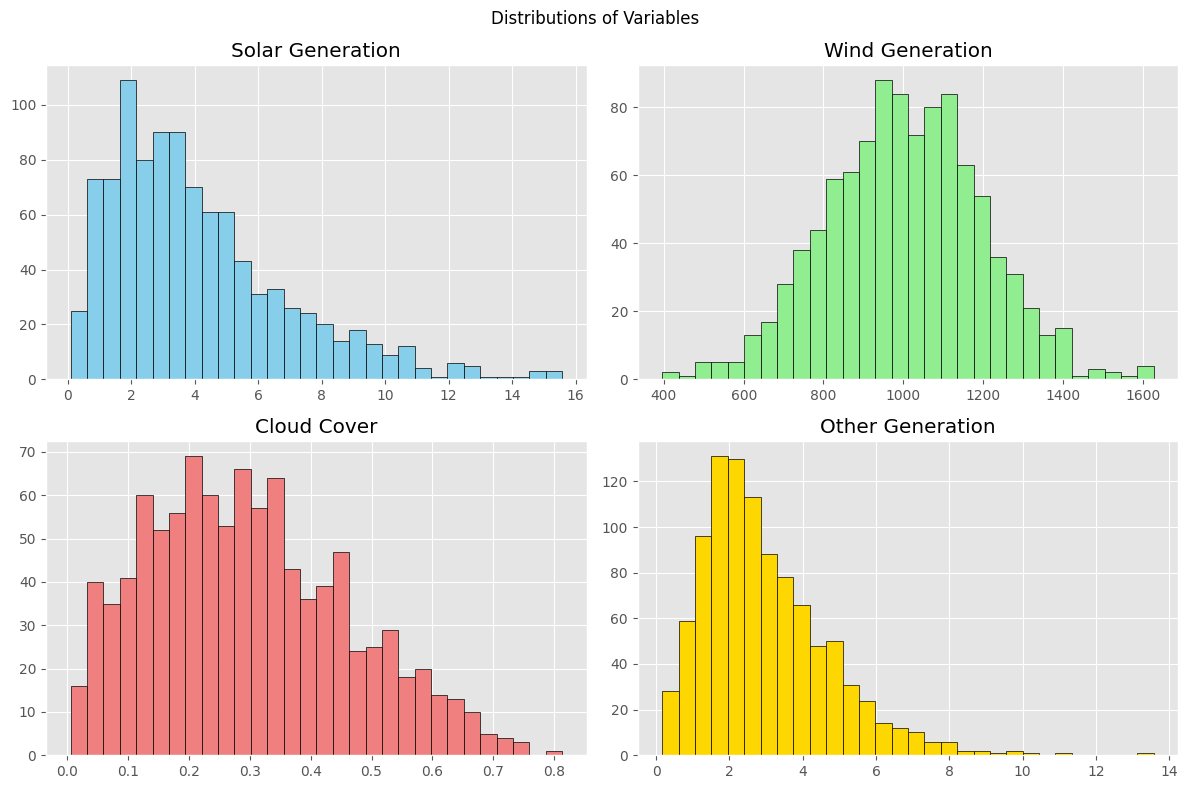

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Generate sample data for each variable (replace these with your actual data)
# num_samples = 1000

# # Sample data for Solar Generation (Gamma distribution)
# solar_shape = 2.0
# solar_rate = 0.5
# solar_samples = np.random.gamma(solar_shape, 1.0 / solar_rate, size=num_samples)

# # Sample data for Wind Generation (Normal distribution)
# wind_mean = 1000.0
# wind_std = 200.0
# wind_samples = np.random.normal(wind_mean, wind_std, size=num_samples)

# # Sample data for Cloud Cover (Beta distribution)
# cloud_alpha = 2.0
# cloud_beta = 5.0
# cloud_samples = np.random.beta(cloud_alpha, cloud_beta, size=num_samples)

# # Sample data for Other Generation (Gamma distribution)
# other_shape = 3.0
# other_rate = 1.0
# other_samples = np.random.gamma(other_shape, 1.0 / other_rate, size=num_samples)

# # Create subplots for each variable
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# # Plot histograms for each variable
# axs[0, 0].hist(solar_samples, bins=30, color='skyblue', edgecolor='black')
# axs[0, 0].set_title('Solar Generation')
# axs[0, 1].hist(wind_samples, bins=30, color='lightgreen', edgecolor='black')
# axs[0, 1].set_title('Wind Generation')
# axs[1, 0].hist(cloud_samples, bins=30, color='lightcoral', edgecolor='black')
# axs[1, 0].set_title('Cloud Cover')
# axs[1, 1].hist(other_samples, bins=30, color='gold', edgecolor='black')
# axs[1, 1].set_title('Other Generation')

# # Add a title to the figure
# fig.suptitle('Distributions of Variables')

# # Adjust layout
# plt.tight_layout()
# plt.show()


In [5]:
# Calculate variance for cloud, solar, and wind
cloud_variance = df["cloud_cover"].var()
solar_variance = df["Solar"].var()
wind_variance = df["Wind"].var()

# Print the variances
print(f"Cloud cover variance: {cloud_variance:.0f}")
print(f"Solar generation variance: {solar_variance:.0f}")
print(f"Wind generation variance: {wind_variance:.0f}")

Cloud cover variance: 1483
Solar generation variance: 19066
Wind generation variance: 237211


# TRying a simple model

### Here we only take 4 days worth of data

In [7]:
import torch
import torch.nn as nn
import pyro
from pyro.nn import PyroModule, PyroSample
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


In [80]:


# Load and preprocess data
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df.drop(columns=['HourUTC', 'PriceArea'])
df['hour'] = df['HourDK'].dt.hour

df_use = df[['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh', 'SpotPriceDKK',
             'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m', 'hour']]

num_test_days = 25
num_train_days = 5

start_date = df_use['HourDK'].min()
end_date = start_date + pd.Timedelta(days=num_train_days + num_test_days)
df_filtered = df_use[(df_use['HourDK'] >= start_date) & (df_use['HourDK'] < end_date)]

train_data = df_filtered[df_filtered['HourDK'] < start_date + pd.Timedelta(days=num_test_days)].copy()
test_data = df_filtered[(df_filtered['HourDK'] >= start_date + pd.Timedelta(days=num_test_days)) & 
                        (df_filtered['HourDK'] < start_date + pd.Timedelta(days=(num_train_days + num_test_days)))].copy()

columns_to_standardize = ['Wind', 'Solar', 'Power', 'GrossConsumptionMWh', 'SpotPriceDKK',
                          'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']

scaler = MinMaxScaler()
train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

X_train = torch.tensor(train_data.drop(columns=['HourDK', 'GrossConsumptionMWh']).values, dtype=torch.float)
y_train = torch.tensor(train_data['GrossConsumptionMWh'].values, dtype=torch.float)
X_test = torch.tensor(test_data.drop(columns=['HourDK', 'GrossConsumptionMWh']).values, dtype=torch.float)
y_test = torch.tensor(test_data['GrossConsumptionMWh'].values, dtype=torch.float)


In [81]:
train_data

,HourDK,Wind,Solar,Power,GrossConsumptionMWh,SpotPriceDKK,hourly_temperature_2m,cloud_cover,hourly_wind_speed_10m,hour
1,2022-01-01 00:00:00,0.694732,0.000039,0.456274,0.157601,0.110447,0.792308,1.0,0.277570,0
3,2022-01-01 01:00:00,0.752610,0.000035,0.308798,0.139196,0.095009,0.823077,1.0,0.273832,1
5,2022-01-01 02:00:00,0.758151,0.000023,0.263145,0.095069,0.097499,0.784615,1.0,0.262617,2
7,2022-01-01 03:00:00,0.667541,0.000049,0.288868,0.052205,0.103916,0.761538,1.0,0.224299,3
9,2022-01-01 04:00:00,0.560406,0.000020,0.314948,0.025576,0.084287,0.769231,1.0,0.171963,4
...,...,...,...,...,...,...,...,...,...,...
1191,2022-01-25 19:00:00,0.365670,0.000362,0.242743,0.636837,0.556409,0.738462,1.0,0.256075,19
1193,2022-01-25 20:00:00,0.348484,0.000300,0.152178,0.522496,0.422103,0.730769,1.0,0.259813,20
1195,2022-01-25 21:00:00,0.376586,0.000201,0.118600,0.412718,0.435764,0.730769,1.0,0.281308,21
1197,2022-01-25 22:00:00,0.465582,0.000143,0.111345,0.311838,0.386099,0.723077,1.0,0.283178,22


In [42]:
X_train

array([[0.00000000e+00, 7.45568607e-01, 1.71273622e-04, 5.51359293e-01,
        2.12003066e-01, 6.82352941e-01, 1.00000000e+00, 3.75711575e-01],
       [1.00000000e+00, 8.19200358e-01, 1.55151986e-04, 2.60121795e-01,
        1.82098446e-01, 7.29411765e-01, 1.00000000e+00, 3.68121442e-01],
       [2.00000000e+00, 8.26249448e-01, 1.03544737e-04, 1.69965945e-01,
        1.86921039e-01, 6.70588235e-01, 1.00000000e+00, 3.45351044e-01],
       [3.00000000e+00, 7.10976197e-01, 2.16606342e-04, 2.20763457e-01,
        1.99351392e-01, 6.35294118e-01, 1.00000000e+00, 2.67552182e-01],
       [4.00000000e+00, 5.74678797e-01, 8.69127319e-05, 2.72267525e-01,
        1.61327747e-01, 6.47058824e-01, 1.00000000e+00, 1.61290323e-01],
       [5.00000000e+00, 5.60940208e-01, 1.13842169e-04, 1.08112273e-01,
        1.72850071e-01, 6.47058824e-01, 1.00000000e+00, 1.68880455e-01],
       [6.00000000e+00, 5.80255192e-01, 1.34286926e-04, 2.59569659e-01,
        1.77901575e-01, 6.94117647e-01, 1.00000000e+00, 2.

In [22]:
import torch
import torch.nn as nn
import pyro
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

class ElectricityDemandModel(PyroModule):
    def __init__(self):
        super().__init__()
        self.in_layer = nn.Linear(7, 10)  # Adjust input size based on valid indices count
        self.tanh = nn.Tanh()
        self.out_layer = nn.Linear(10, 1)

    def forward(self, X):
        # Assuming X is a tensor with shape [batch_size, num_features]
        linear_columns = torch.tensor([5, 6])  # Assuming columns 5 and 6 correspond to Wind and Solar
        non_linear_columns = torch.tensor([0, 1, 2, 3, 4, 7, 8])  # Adjust indices accordingly

        X_nn = torch.index_select(X, dim=1, index=non_linear_columns)
        X_nn = self.tanh(self.in_layer(X_nn))
        
        X_linear = torch.index_select(X, dim=1, index=linear_columns)
        
        X_combined = torch.cat((X_nn, X_linear), dim=1)
        output = self.out_layer(X_combined)
        
        return output

# Assuming train_X and train_y are your training data
model = ElectricityDemandModel()
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
adam = Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

n_steps = 5000
for step in range(n_steps):
    elbo = svi.step(train_X, train_y)
    if step % 100 == 0:
        print(f"Step {step} : ELBO = {elbo}")

# Making predictions
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
predictions = predictive(train_X)


TypeError: ElectricityDemandModel.forward() takes 2 positional arguments but 3 were given

In [16]:
class FFNN_interpretable(PyroModule):
    def __init__(self, n_in_non_linear, n_hidden, n_out):
        super(FFNN_interpretable, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in_non_linear, n_hidden, bias=True)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in_non_linear]).to_event(2))
        
        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden, bias=True)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        
        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out, bias=True)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))
        
        # using tanh hyperparam
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        linear_columns = torch.tensor([1, 5, 9, 10])  # Update indices based on your feature set
        non_linear_columns = torch.tensor([0, 2, 3, 4, 6, 7, 8, 11])
        
        X_nn = torch.index_select(X, dim=1, index=non_linear_columns)
        X_nn = self.tanh(self.in_layer(X_nn))
        X_nn = self.tanh(self.h_layer(X_nn))
        X_nn = self.out_layer(X_nn)
        nn_out = X_nn.squeeze(-1)
        
        beta_lin = pyro.sample("beta", dist.Normal(0, 1).expand([len(linear_columns)]).to_event(1))
        X_linear = torch.index_select(X, dim=1, index=linear_columns)
        with pyro.plate("observations"):
            linear_out = X_linear.matmul(beta_lin)
            y = pyro.sample("obs", dist.Normal(nn_out + linear_out, 0.1), obs=y)
        
        return nn_out + linear_out

# Model instantiation
n_in_non_linear = X_train.shape[1] - len([1, 5, 9, 10])  # Adjust based on your feature selection
model_FFNN_interpretable = FFNN_interpretable(n_in_non_linear=n_in_non_linear, n_hidden=10, n_out=1)

# Define the guide
guide = AutoDiagonalNormal(model_FFNN_interpretable)


In [17]:
pyro.clear_param_store()
n_steps = 5000
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)
elbo = Trace_ELBO(num_particles=3)
svi = SVI(model_FFNN_interpretable, guide, optimizer, loss=elbo)

# Training loop
for step in range(n_steps):
    loss = svi.step(X_train, y_train)
    if step % 100 == 0:
        print(f'Step {step} : loss = {loss}')

# Evaluate the model on the test data
model_FFNN_interpretable.eval()
guide.eval()
with torch.no_grad():
    predictive = pyro.infer.Predictive(model_FFNN_interpretable, guide=guide, num_samples=1000)
    samples = predictive(X_test)
    y_pred = samples['obs'].mean(dim=0)
    mse = torch.mean((y_pred - y_test) ** 2)
    print(f'Test MSE: {mse}')


RuntimeError: INDICES element is out of DATA bounds, id=8 axis_dim=8
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites:

In [14]:
num_test_days= 4
num_train_days = 1

# Filter data for the first 4 days
start_date = df_use['HourDK'].min()
end_date = start_date + pd.Timedelta(days=num_train_days + num_test_days)
df_filtered = df_use[(df_use['HourDK'] >= start_date) & (df_use['HourDK'] < end_date)]


# Split into training (first 3 days) and testing (4th day)
train_data = df_filtered[df_filtered['HourDK'] < start_date + pd.Timedelta(days=num_test_days)].copy()
test_data = df_filtered[(df_filtered['HourDK'] >= start_date + pd.Timedelta(days=num_test_days)) & (df_filtered['HourDK'] < start_date + pd.Timedelta(days=(num_train_days+num_test_days)))].copy()
# train_data = df_filtered[df_filtered['HourDK'] < start_date + pd.Timedelta(days=3)]
# test_data = df_filtered[(df_filtered['HourDK'] >= start_date + pd.Timedelta(days=3)) & (df_filtered['HourDK'] < start_date + pd.Timedelta(days=4))]



# Columns to standardize
columns_to_standardize = ['Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
                          'SpotPriceDKK', 'hourly_temperature_2m',
                          'cloud_cover', 'hourly_wind_speed_10m']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
train_data.loc[:, columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
test_data.loc[:, columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

# Verify the standardization
print("Training data range:", train_data['HourDK'].min(), "to", train_data['HourDK'].max())
print("Testing data range:", test_data['HourDK'].min(), "to", test_data['HourDK'].max())
train_data

Training data range: 2022-01-01 00:00:00 to 2022-01-04 23:00:00
Testing data range: 2022-01-05 00:00:00 to 2022-01-05 23:00:00


,HourDK,Wind,Solar,Power,GrossConsumptionMWh,SpotPriceDKK,hourly_temperature_2m,cloud_cover,hourly_wind_speed_10m,hour
1,2022-01-01 00:00:00,0.745569,0.000171,0.551359,0.183215,0.212003,0.682353,1.00,0.375712,0
3,2022-01-01 01:00:00,0.819200,0.000155,0.260122,0.161818,0.182098,0.729412,1.00,0.368121,1
5,2022-01-01 02:00:00,0.826249,0.000104,0.169966,0.110520,0.186921,0.670588,1.00,0.345351,2
7,2022-01-01 03:00:00,0.710976,0.000217,0.220763,0.060689,0.199351,0.635294,1.00,0.267552,3
9,2022-01-01 04:00:00,0.574679,0.000087,0.272268,0.029733,0.161328,0.647059,1.00,0.161290,4
...,...,...,...,...,...,...,...,...,...,...
183,2022-01-04 19:00:00,0.789723,0.000616,0.970713,0.809808,0.820885,0.070588,0.50,0.590133,19
185,2022-01-04 20:00:00,0.828045,0.000477,0.793391,0.682509,0.780763,0.070588,0.46,0.540797,20
187,2022-01-04 21:00:00,0.849488,0.000384,0.661774,0.558225,0.678268,0.047059,0.32,0.489564,21
189,2022-01-04 22:00:00,0.885016,0.000285,0.515875,0.491041,0.588653,0.094118,0.40,0.696395,22


In [9]:

class FFNN_interpretable(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN_interpretable, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        X_nn = self.tanh(self.in_layer(X))
        X_nn = self.tanh(self.h_layer(X_nn))
        X_nn = self.out_layer(X_nn)
        nn_out = X_nn.squeeze(-1)

        # Define priors for coefficients
        tau = pyro.sample("tau", dist.Normal(0, 1))
        kappa = pyro.sample("kappa", dist.Normal(0, 1))
        gamma = pyro.sample("gamma", dist.HalfCauchy(1))
        omega = pyro.sample("omega", dist.Normal(0, 1))
        sigma = pyro.sample("sigma", dist.HalfCauchy(1))
        rho_1 = pyro.sample("rho_1", dist.LogNormal(0, 1))
        rho_2 = pyro.sample("rho_2", dist.Normal(0, 1))
        partial = pyro.sample("partial", dist.Normal(0, 1))
        epsilon = pyro.sample("epsilon", dist.Normal(0, 1))
        alpha = pyro.sample("alpha", dist.Normal(0, 1))
        beta = pyro.sample("beta", dist.Normal(0, 1))

        with pyro.plate("data", X.shape[0]):
            # Generative process
            temp_mean = X[:, 0]
            temp_var = pyro.sample("temp_var", dist.Normal(0, 1))
            temp = pyro.sample("temp", dist.Normal(temp_mean, temp_var))
            
            cloud_mean = X[:, 1]
            cloud_var = pyro.sample("cloud_var", dist.Normal(0, 1))
            cloud = pyro.sample("cloud", dist.Normal(cloud_mean, cloud_var))
            
            wind_mean = X[:, 2]
            wind_var = pyro.sample("wind_var", dist.Normal(0, 1))
            wind = pyro.sample("wind", dist.Normal(wind_mean, wind_var))

            solar_gen = pyro.sample("solar_gen", dist.Beta(tau * temp + kappa * cloud, gamma))
            wind_gen = pyro.sample("wind_gen", dist.Normal(omega * wind, sigma))
            price = pyro.sample("price", dist.Normal(solar_gen * rho_1 + wind * rho_2, partial))
            demand = pyro.sample("demand", dist.Normal(beta * X[:, -1] + epsilon * price, alpha))

            y = pyro.sample("obs", dist.Normal(nn_out + demand, 0.1), obs=y)
            
        return y

In [18]:
# turn to tensor and x_y split
X_train = torch.tensor(train_data[columns_to_standardize + ['hour']].values, dtype=torch.float)
y_train = torch.tensor(train_data['GrossConsumptionMWh'].values, dtype=torch.float)
X_test = torch.tensor(test_data[columns_to_standardize + ['hour']].values, dtype=torch.float)
y_test = torch.tensor(test_data['GrossConsumptionMWh'].values, dtype=torch.float)

# Define model and guide
model = FFNN_interpretable(n_in=X_train.shape[1], n_hidden=4, n_out=1)
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO()
svi = SVI(model, guide, optimizer, loss=elbo)

# Training
n_steps = 10000
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

# Testing
model.eval()
with torch.no_grad():
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
    samples = predictive(X_test)
    pred_mean = samples['obs'].mean(0).detach().numpy()
    pred_std = samples['obs'].std(0).detach().numpy()

print("Predictions mean:", pred_mean)
print("Predictions std:", pred_std)

ValueError: Expected parameter scale (Tensor of shape (72,)) of distribution Normal(loc: torch.Size([72]), scale: torch.Size([72])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([ 0.5587,  0.2738,  0.8096, -0.0830,  0.1653,  0.0365,  0.4055, -0.2221,
        -0.0580, -0.1356, -0.0138,  0.1004,  0.2090,  0.3655, -0.1993, -0.2844,
        -0.0930, -0.0354,  0.2636, -0.1880, -0.3533,  0.1940,  0.1454, -0.3593,
         0.3825, -0.0858,  0.1209,  0.1894, -0.2885, -0.4962, -0.2875,  0.1833,
        -0.3521,  0.2922,  0.0448,  0.0452, -0.1906, -0.3240, -0.2193, -0.3684,
        -0.0601, -0.0330, -0.2282, -0.4648,  0.0862,  0.3412,  0.2018, -0.7457,
         0.5008,  0.0800, -0.2849, -0.0140, -0.1904,  0.3886,  0.0804,  0.3193,
        -0.0609, -0.1640,  0.6575, -0.3052,  0.4945,  0.0747,  0.6089, -0.4128,
        -0.0216,  0.0065,  0.2053, -0.4423, -0.0207,  0.4187,  0.2927, -0.1666])
        Trace Shapes:         
         Param Sites:         
        Sample Sites:         
 in_layer.weight dist    | 4 9
                value    | 4 9
  h_layer.weight dist    | 4 4
                value    | 4 4
out_layer.weight dist    | 1 4
                value    | 1 4
             tau dist    |    
                value    |    
           kappa dist    |    
                value    |    
           gamma dist    |    
                value    |    
           omega dist    |    
                value    |    
           sigma dist    |    
                value    |    
           rho_1 dist    |    
                value    |    
           rho_2 dist    |    
                value    |    
         partial dist    |    
                value    |    
         epsilon dist    |    
                value    |    
           alpha dist    |    
                value    |    
            beta dist    |    
                value    |    
        temp_var dist 72 |    
                value 72 |    
Trace Shapes:
 Param Sites:
Sample Sites:

In [20]:
import pyro
import pyro.distributions as dist
from torch import nn
import torch

class SimpleRegressionModel(nn.Module):
    def __init__(self):
        super(SimpleRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # One input feature, one output

    def forward(self, x):
        return self.linear(x)

def model(data):
    # Define the priors
    loc_weight = torch.zeros(1, 1)
    scale_weight = torch.ones(1, 1)
    loc_bias = torch.zeros(1)
    scale_bias = torch.ones(1)

    weight = pyro.sample("weight", dist.Normal(loc_weight, scale_weight))
    bias = pyro.sample("bias", dist.Normal(loc_bias, scale_bias))

    # Define the linear regression model
    regression_model = SimpleRegressionModel()

    # Sample y (target) from the model
    with pyro.plate("data", len(data)):
        x_data = data[:, :-1]  # Assuming the last column is the target
        y_data = data[:, -1]   # Assuming the last column is the target
        output = regression_model(x_data).squeeze(-1)
        pyro.sample("obs", dist.Normal(output * weight + bias, 1), obs=y_data)

# Guide (Variational Distribution)
def guide(data):
    # Variational parameters for weight and bias
    weight_loc = pyro.param("weight_loc", torch.randn(1, 1))
    weight_scale = pyro.param("weight_scale", torch.ones(1, 1), constraint=dist.constraints.positive)
    bias_loc = pyro.param("bias_loc", torch.randn(1))
    bias_scale = pyro.param("bias_scale", torch.ones(1), constraint=dist.constraints.positive)

    # Register variational parameters with Pyro
    weight = pyro.sample("weight", dist.Normal(weight_loc, weight_scale))
    bias = pyro.sample("bias", dist.Normal(bias_loc, bias_scale))


In [23]:
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyro.contrib.autoguide import AutoDiagonalNormal

# Turn data into tensors and split
X_train = torch.tensor(train_data[columns_to_standardize + ['hour']].values, dtype=torch.float)
y_train = torch.tensor(train_data['GrossConsumptionMWh'].values, dtype=torch.float)
X_test = torch.tensor(test_data[columns_to_standardize + ['hour']].values, dtype=torch.float)
y_test = torch.tensor(test_data['GrossConsumptionMWh'].values, dtype=torch.float)

# Define model and guide
model = FFNN_interpretable(n_in=X_train.shape[1], n_hidden=4, n_out=1)
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))


ValueError: Expected parameter scale (Tensor of shape (72,)) of distribution Normal(loc: torch.Size([72]), scale: torch.Size([72])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([ 0.0632, -0.2032,  0.1712,  0.0203,  0.3153,  0.2630, -0.1012, -0.3026,
         0.3640,  0.2239, -0.0246,  0.3491, -0.1515,  0.0511, -0.7314,  0.4017,
        -0.1410, -0.0797, -0.1389, -0.1957,  0.1655, -0.1116, -0.2433, -0.0127,
         0.3630,  0.3948,  0.0033, -0.2865, -0.5030, -0.4530,  0.4010, -0.2983,
         0.1823,  0.0163,  0.3735, -0.0680, -0.6038, -0.0459, -0.1566,  0.5265,
         0.6146,  0.6296,  0.9411, -0.1432,  0.1632, -0.2827,  0.2866, -0.4572,
         0.2863, -0.0141,  0.2521, -0.1270,  0.6157, -0.4119,  0.0356,  0.0191,
         0.0681, -0.2479, -0.5005, -0.1191, -0.5843, -0.5364,  0.1144,  0.2193,
         0.3119, -0.3349,  0.3873, -0.5682,  0.7086,  0.1105,  0.0746,  0.0069])
        Trace Shapes:         
         Param Sites:         
        Sample Sites:         
 in_layer.weight dist    | 4 9
                value    | 4 9
  h_layer.weight dist    | 4 4
                value    | 4 4
out_layer.weight dist    | 1 4
                value    | 1 4
             tau dist    |    
                value    |    
           kappa dist    |    
                value    |    
           gamma dist    |    
                value    |    
           omega dist    |    
                value    |    
           sigma dist    |    
                value    |    
           rho_1 dist    |    
                value    |    
           rho_2 dist    |    
                value    |    
         partial dist    |    
                value    |    
         epsilon dist    |    
                value    |    
           alpha dist    |    
                value    |    
            beta dist    |    
                value    |    
        temp_var dist 72 |    
                value 72 |    
Trace Shapes:
 Param Sites:
Sample Sites:

In [25]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
import numpy as np

# Define the model
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_layer = PyroModule[torch.nn.Linear](in_features, 4)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([4, in_features]).to_event(2))
        self.in_layer.bias = PyroSample(dist.Normal(0., 1.).expand([4]).to_event(1))
        self.h_layer = PyroModule[torch.nn.Linear](4, 4)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([4, 4]).to_event(2))
        self.h_layer.bias = PyroSample(dist.Normal(0., 1.).expand([4]).to_event(1))
        self.out_layer = PyroModule[torch.nn.Linear](4, out_features)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, 4]).to_event(2))
        self.out_layer.bias = PyroSample(dist.Normal(0., 1.).expand([out_features]).to_event(1))

    def forward(self, X, y=None):
        temp_var = pyro.sample("temp_var", dist.Normal(0, 1))
        temp_var = torch.nn.functional.softplus(temp_var)  # Apply softplus to ensure positivity
        temp = pyro.sample("temp", dist.Normal(0, temp_var))
        cloud_mean = X[:, 1]

# Generate some synthetic data
np.random.seed(0)
X_train = np.random.randn(100, 2).astype(np.float32)
y_train = X_train[:, 0] + X_train[:, 1] * 3.0 + 0.1 * np.random.randn(100)

# Run SVI
pyro.clear_param_store()
model = BayesianRegression(2, 1)
guide = AutoDiagonalNormal(model)
optim = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
n_steps = 10000
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))


[0] ELBO: 1.3
[500] ELBO: -0.0
[1000] ELBO: -1.5
[1500] ELBO: 0.6
[2000] ELBO: 0.2
[2500] ELBO: 0.5
[3000] ELBO: 0.2
[3500] ELBO: 0.1
[4000] ELBO: -0.9
[4500] ELBO: 1.1
[5000] ELBO: 0.7
[5500] ELBO: 1.0
[6000] ELBO: -0.7
[6500] ELBO: 0.0
[7000] ELBO: 0.7
[7500] ELBO: 0.3
[8000] ELBO: 0.1
[8500] ELBO: 0.1
[9000] ELBO: 0.5
[9500] ELBO: -0.4


In [6]:
# import matplotlib.pyplot as plt

# # Assuming your DataFrame is loaded as 'df'

# # Define desired variable names for stacked bar chart
# var_names = ['Solar', 'Wind', 'cloud_cover', 'Power']  # Assuming 'Other' represents a specific column

# # Extract data for each variable based on column names
# data_dict = {name: df[name] for name in var_names}

# # Create the stacked bar chart
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.stackplot(data_dict.keys(), data_dict.values(), labels=var_names, colors=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
# ax.set_title('Energy Production Breakdown')
# ax.set_xlabel('Samples (based on index)')
# ax.set_ylabel('Values')
# ax.legend(title='Energy Source')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.tight_layout()
# plt.show()

In [7]:
# import numpyro
# import numpyro.distributions as dist
# from numpyro import handlers
# from numpyro.infer import MCMC, NUTS

# import jax
# import jax.numpy as jnp
# from jax import random, vmap
# from jax.scipy.special import logsumexp
# from jax import lax

In [8]:
pip install jax

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install numpyro

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
# import numpyro
# import numpyro.distributions as dist

In [11]:

#   """
#   This model defines a probabilistic relationship between Wind, Solar, Power, 
#   and Gross Consumption using a partially directed structure.

#   Args:
#       data: A dictionary containing observed values for each variable.

#   Returns:
#       No return value, samples are collected within the model definition.
#   """

#   # Extract data
#   wind = df["Wind"]
#   solar = df["Solar"]
#   power = df["Power"]

#   # Define coefficients (assuming linear relationships for now)
#   beta_wind = pyro.sample(name="beta_wind", fn=dist.Normal(loc=0., scale=1.))
#   beta_solar = pyro.sample(name="beta_solar", fn=dist.Normal(loc=0., scale=1.))
#   beta_power = pyro.sample(name="beta_power", fn=dist.Normal(loc=0., scale=1.))

#   # Define a base distribution for gross consumption (can be adjusted based on your findings)
#   mu_0 = pyro.param(name="mu_0", default=0.0)  # Base mean
#   sigma_0 = pyro.param(name="sigma_0", default=1.0)  # Base standard deviation

#   # Model the gross consumption
#   gross_consumption = beta_wind * wind + beta_solar * solar + beta_power * power + mu_0
#   pyro.sample(
#       name="gross_consumption", fn=dist.Normal(loc=gross_consumption, scale=sigma_0), obs=data["GrossConsumptionMWh"]
#   )

# # Example usage (assuming you have your data loaded in a dictionary named 'data')
# model(data)


In [12]:
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# import numpy as np

# # Define train and test indices
# train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# # Define train and test sets
# train_data = df.loc[train_idx]
# test_data = df.loc[test_idx]

# X_train = train_data.drop(columns=['GrossConsumptionMWh'])
# y_train = train_data['GrossConsumptionMWh'].values

# X_test = test_data.drop(columns=['GrossConsumptionMWh'])
# y_test = test_data['GrossConsumptionMWh'].values

# # Define guide fuanction
# model = EnergyModel(n_in=X_train.shape[1], n_hidden=4, n_out=1) 
# guide = AutoDiagonalNormal(model)

# # Reset parameter values
# pyro.clear_param_store()

# # Define the number of optimization steps
# n_steps = 10000

# # Setup the optimizer
# adam_params = {"lr": 0.01}
# optimizer = ClippedAdam(adam_params)

# # Setup the inference algorithm
# elbo = Trace_ELBO(num_particles=1)
# svi = SVI(model, guide, optimizer, loss=elbo)

# # Do gradient steps
# train_losses = []
# for step in range(n_steps):
#     elbo = svi.step(torch.tensor(X_train.values, dtype=torch.float32), 
#                     torch.tensor(y_train, dtype=torch.float32))
#     train_losses.append(elbo)
#     if step % 500 == 0:
#         print("[%d] ELBO: %.1f" % (step, elbo))

# # Plot the training loss curve
# plt.plot(train_losses)
# plt.xlabel("Steps")
# plt.ylabel("ELBO")
# plt.title("Training Loss Curve")
# plt.show()


In [13]:
# from pyro.infer import Predictive

# # Get posterior samples for beta
# predictive = Predictive(model, guide=guide, num_samples=1000,
#                         return_sites=("beta",))
# samples = predictive(X_train.values, y_train)

# print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

# # Make predictions for test set
# predictive = Predictive(model, guide=guide, num_samples=1000,
#                         return_sites=("obs", "_RETURN"))
# samples = predictive(torch.tensor(X_test.values, dtype=torch.float32))

# y_pred = samples["obs"].mean(axis=0).detach().numpy()
# mae = np.mean(np.abs(y_test - y_pred))
# print("MAE:", mae)

# # Plot the true vs predicted values
# plt.scatter(y_test, y_pred)
# plt.xlabel("True Gross Consumption")
# plt.ylabel("Predicted Gross Consumption")
# plt.title("True vs Predicted Gross Consumption")
# plt.show()

In [14]:
import torch
import pandas as pd
import numpy as np
import pyro
import pyro.distributions as dist

In [15]:
def model(X, z1, z2, z3):
    # Define initial values for means
    
    # T_prev = X[0, 0]
    # C_prev = X[0, 1]
    # W_prev = X[0, 2]
    # O_prev = X[0, 3]

    # Define priors for model parameters
    # tau = pyro.sample("tau", dist.Normal(0, 1))
    # kappa = pyro.sample("kappa", dist.Normal(0, 1))
    # gamma = pyro.sample("gamma", dist.HalfCauchy(1))
    # omega = pyro.sample("omega", dist.Normal(0, 1))
    # sigma = pyro.sample("sigma", dist.HalfCauchy(1))
    # rho_1 = pyro.sample("rho_1", dist.HalfCauchy(1))
    # rho_2 = pyro.sample("rho_2", dist.Normal(0, 1))
    # partial = pyro.sample("partial", dist.Normal(0, 1))
    # epsilon = pyro.sample("epsilon", dist.Normal(0, 1))
    # alpha = pyro.sample("alpha", dist.Normal(0, 1))
    # beta = pyro.sample("beta", dist.Normal(0, 1))

    tau = pyro.sample("tau", dist.HalfCauchy(1))
    kappa = pyro.sample("kappa", dist.HalfCauchy(1))
    gamma = pyro.sample("gamma", dist.HalfCauchy(1))
    omega = pyro.sample("omega", dist.HalfCauchy(1))
    sigma = pyro.sample("sigma", dist.HalfCauchy(1))
    rho_1 = pyro.sample("rho_1", dist.HalfCauchy(1))
    rho_2 = pyro.sample("rho_2", dist.HalfCauchy(1))
    partial = pyro.sample("partial", dist.HalfCauchy(1))
    epsilon = pyro.sample("epsilon", dist.HalfCauchy(1))
    alpha = pyro.sample("alpha", dist.HalfCauchy(1))
    beta = pyro.sample("beta", dist.HalfCauchy(1))

    D_t_vector = torch.zeros(len(X))

    # For each time period t
    for t in range(1, len(X) + 1):
        # # Mean of temperature = don't draw, use previous period
        # T_t = T_prev

        # # Variance of temperature = z1
        # # Mean of Cloud cover = don't draw, use previous period
        # C_t = C_prev

        # # Variance of Cloud cover = z2
        # # Mean of Wind = don't draw, use previous period
        # W_t = W_prev

        # # Variance of Wind = z3
        # # Other generation = O_t
        # O_t = O_prev

        # Update previous values FROM TENSOR SO FORMAT WEIRD
        T_prev = X[t - 1, 0]  # Assuming temperature is the first column
        C_prev = X[t - 1, 1]  # Assuming cloud cover is the second column
        W_prev = X[t - 1, 2]  # Assuming wind speed is the third column
        O_prev = X[t - 1, 3]  # Assuming other generation is the fourth column

        # Draw samples for other variables
        T_t = pyro.sample(f"T_{t}", dist.Normal(T_prev, z1))
        C_t = pyro.sample(f"C_{t}", dist.Normal(C_prev, z2))
        W_t = pyro.sample(f"W_{t}", dist.Normal(W_prev, z3))
        S_t = pyro.sample(f"S_{t}", dist.Beta(abs(tau * T_t + kappa * C_t), gamma))
        
        Gw_t = pyro.sample(f"Gw_{t}", dist.Normal(omega * W_t, sigma))
        P_t = pyro.sample(f"P_{t}", dist.Normal(S_t * rho_1 + W_t * rho_2, partial))
        # D_t = pyro.sample(f"D_{t}", dist.Normal(beta * O_prev + epsilon * P_t, alpha))
        
        # Ensure that the scale parameter is positive by taking the absolute value
        D_t = pyro.sample(f"D_{t}", dist.Normal(beta * O_prev + epsilon * P_t, torch.abs(alpha)))
        D_t_vector[t - 1] = D_t

    return (D_t_vector)


In [72]:
len(df_use)

18960

In [16]:
df_use.columns

Index(['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
       'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover',
       'hourly_wind_speed_10m'],
      dtype='object')

In [59]:
num_total_obs = len(df_use)
num_train_obs = int(0.8 * num_total_obs)
num_test_obs = num_total_obs - num_train_obs

columns = ['hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m', 'Power']

X_train = torch.tensor(df_use[columns][:num_train_obs].values, dtype=torch.float32)
X_test = torch.tensor(df_use[columns][num_train_obs:].values, dtype=torch.float32)


y_train = torch.tensor(df_use["GrossConsumptionMWh"][:num_train_obs].values, dtype=torch.float32)
y_test = torch.tensor(df_use["GrossConsumptionMWh"][num_train_obs:].values, dtype=torch.float32)


In [18]:
X_train


tensor([[  7.0000, 100.0000,   4.1400, 789.8923],
        [  7.4000, 100.0000,   4.1000, 644.4583],
        [  6.9000, 100.0000,   3.9800, 599.4376],
        ...,
        [ 13.0000,   1.0000,   4.9200,  80.3416],
        [ 12.8000,   1.0000,   4.9200,  80.0201],
        [ 12.8000,  16.0000,   4.9200,  76.8625]])

In [19]:
df_use["GrossConsumptionMWh"]

1        1415.517875
3        1394.053760
5        1342.593361
7        1292.604709
9        1261.550580
            ...     
37911    1950.231822
37913    1856.984338
37915    1767.729341
37916    1654.056866
37919    1566.990822
Name: GrossConsumptionMWh, Length: 18960, dtype: float64

In [20]:

# 4. Run the model for the training set
temp_var = df_use['hourly_temperature_2m'].var() #6.6392  # Set the value of z1
cloud_var = df_use['cloud_cover'].var()  # Set the value of z2
win_var = df_use['hourly_wind_speed_10m'].var()  # Set the value of z3



# pyro.clear_param_store()  # aClear parameter store before running the model
pred_demand = model(X_train, temp_var, cloud_var, win_var)


In [21]:
np.array(pred_demand)

array([1842.8137 , 1500.5037 , 1393.5516 , ...,  186.85576,  184.41179,
        179.57335], dtype=float32)

In [34]:
pred_actual = df_use["GrossConsumptionMWh"][:num_train_obs].values

In [35]:
pred_actual= pred_actual

In [36]:
torch.tensor(pred_actual)

tensor([1415.5179, 1394.0538, 1342.5934,  ..., 1212.9663, 1135.6820,
        1120.3859], dtype=torch.float64)

In [37]:
# Assuming df_use is your DataFrame containing the data
variance_temperature = df_use['hourly_temperature_2m'].var()
variance_cloud_cover = df_use['cloud_cover'].var()
variance_wind_speed = df_use['hourly_wind_speed_10m'].var()

print("Variance of Temperature:", variance_temperature)
print("Variance of Cloud Cover:", variance_cloud_cover)
print("Variance of Wind Speed:", variance_wind_speed)

Variance of Temperature: 44.08146685608273
Variance of Cloud Cover: 1482.9263884530535
Variance of Wind Speed: 4.23534777528591


Mean Absolute Percentage Error (MAPE): 35.91%
Mean Squared Error (MSE): 381202.19
Root Mean Squared Error (RMSE): 617.42


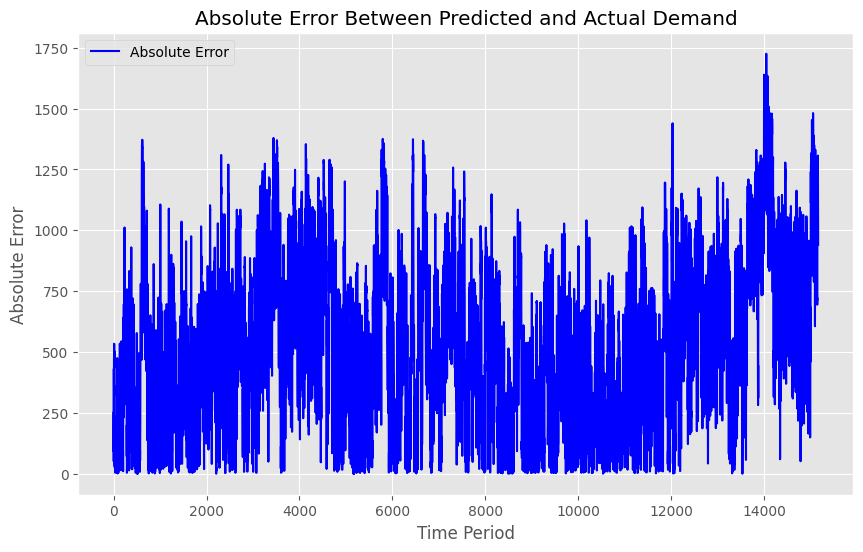

In [38]:
# Calculate absolute error
abs_error = torch.abs(pred_demand - pred_actual)

# Calculate Mean Absolute Percentage Error (MAPE)
actual = torch.tensor(pred_actual)
mape = torch.mean(torch.abs((actual - pred_demand) / actual)) * 100

# Calculate Mean Squared Error (MSE)
mse = torch.mean((pred_demand - actual) ** 2)

# Calculate Root Mean Squared Error (RMSE)
rmse = torch.sqrt(mse)

# Print error metrics
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Plot the absolute error
plt.figure(figsize=(10, 6))
plt.plot(abs_error, color='blue', label='Absolute Error')
plt.title('Absolute Error Between Predicted and Actual Demand')
plt.xlabel('Time Period')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


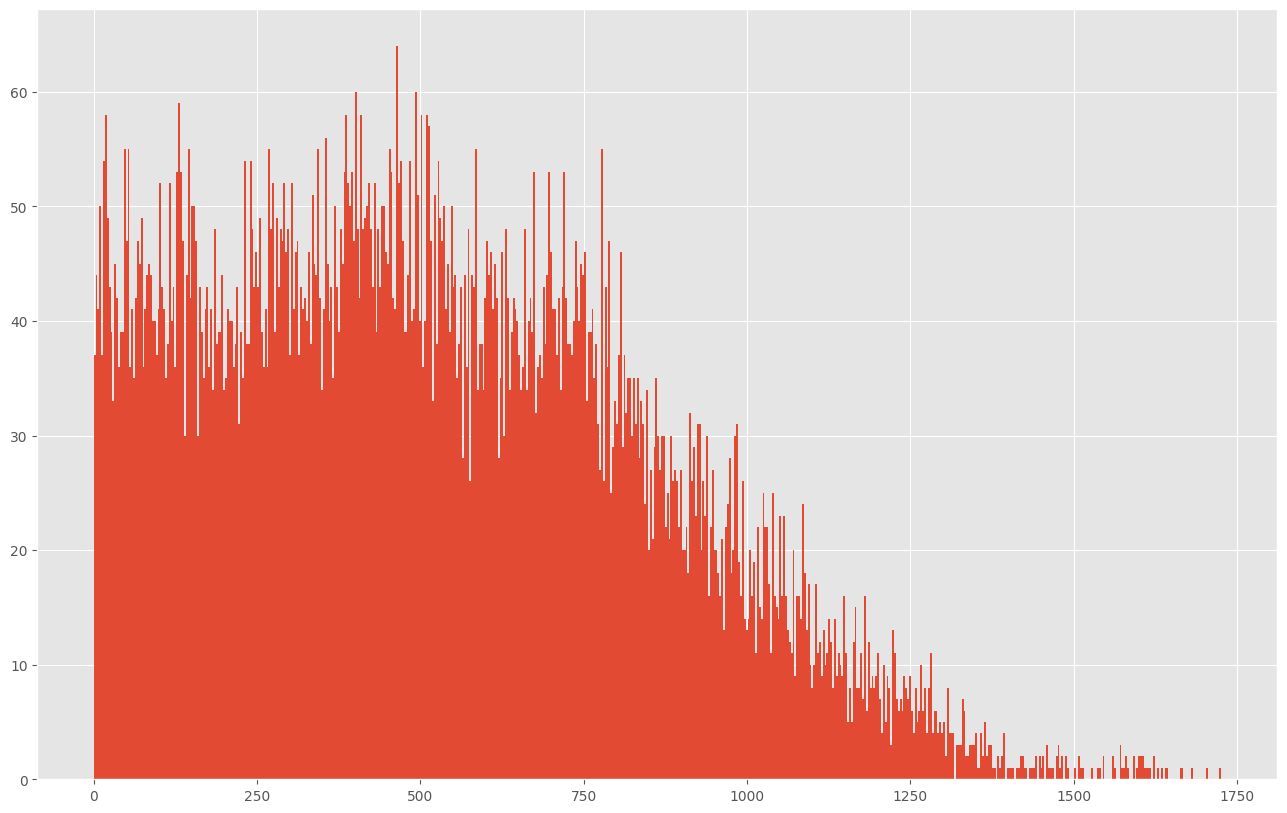

In [51]:
plt.hist(abs_error, bins=600)
plt.show()

array([1842.8137 , 1500.5037 , 1393.5516 , ...,  186.85576,  184.41179,
        179.57335], dtype=float32)

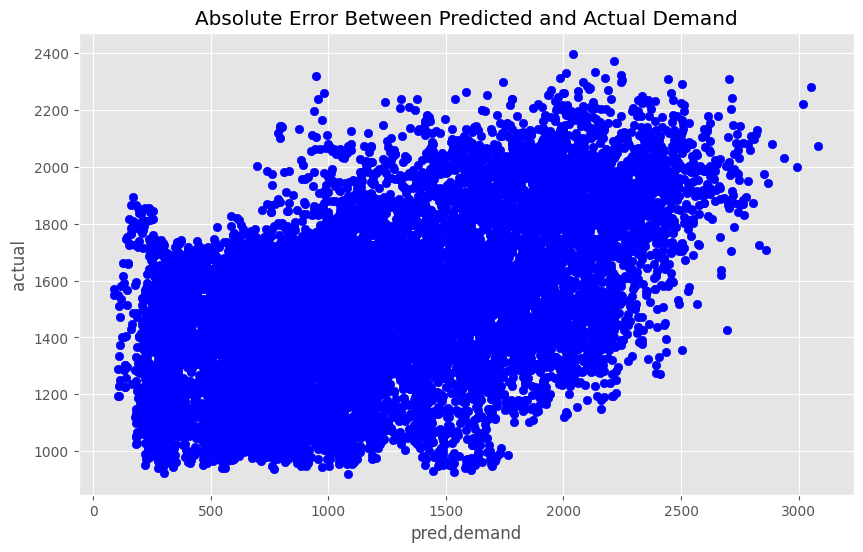

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(np.array(pred_demand), pred_actual , color='blue')
plt.title('Absolute Error Between Predicted and Actual Demand')
plt.xlabel('pred,demand')
plt.ylabel('actual')
# plt.legend()
plt.grid(True)
plt.show()

In [44]:
np.sqrt(pred_demand.var()), torch.mean(pred_demand)

(tensor(607.7627), tensor(1165.3004))

In [49]:
np.sqrt(pred_actual.var()), np.mean(pred_actual)

(283.7509421162235, 1502.4549882495385)

In [39]:
np.array(pred_demand)[0:10],pred_actual[0:10]

(array([1842.8137, 1500.5037, 1393.5516, 1454.3148, 1515.5133, 1321.5791,
        1497.8533, 1579.3402, 1820.7671, 1703.6394], dtype=float32),
 array([1415.517875, 1394.05376 , 1342.593361, 1292.604709, 1261.55058 ,
        1231.723792, 1273.265994, 1308.530874, 1344.570144, 1401.806261]))

In [28]:
(np.array(pred_demand), pred_actual[0:10])

(array([1842.8137 , 1500.5037 , 1393.5516 , ...,  186.85576,  184.41179,
         179.57335], dtype=float32),
 array([141.5517875, 139.405376 , 134.2593361, 129.2604709, 126.155058 ,
        123.1723792, 127.3265994, 130.8530874, 134.4570144, 140.1806261]))

In [29]:
correlation = np.corrcoef(pred_demand, pred_actual)[0, 1]
print(correlation)


0.5286730897589154


In [ ]:
y_train

In [62]:
np.array(y_train)

array([1415.5178, 1394.0537, 1342.5934, ..., 1212.9663, 1135.682 ,
       1120.386 ], dtype=float32)

In [ ]:
mcmc.print_summary()

In [69]:
X_train.numpy()[:100]

array([[   7.     ,  100.     ,    4.14   ,  789.89233],
       [   7.4    ,  100.     ,    4.1    ,  644.4583 ],
       [   6.9    ,  100.     ,    3.98   ,  599.43756],
       [   6.6    ,  100.     ,    3.57   ,  624.80414],
       [   6.7    ,  100.     ,    3.01   ,  650.5235 ],
       [   6.7    ,  100.     ,    3.05   ,  568.55   ],
       [   7.1    ,  100.     ,    3.32   ,  644.1826 ],
       [   7.5    ,  100.     ,    3.2    ,  677.4195 ],
       [   7.7    ,  100.     ,    2.84   ,  781.747  ],
       [   7.8    ,  100.     ,    2.65   ,  732.0191 ],
       [   7.7    ,  100.     ,    2.6    ,  707.3017 ],
       [   7.9    ,  100.     ,    2.79   ,  835.0292 ],
       [   8.     ,  100.     ,    2.16   ,  900.69977],
       [   8.5    ,  100.     ,    2.41   ,  870.65436],
       [   7.9    ,  100.     ,    2.31   ,  896.1073 ],
       [   8.3    ,  100.     ,    2.8    ,  901.51697],
       [   8.4    ,  100.     ,    3.1    ,  933.1113 ],
       [   8.4    ,  100.     ,

In [71]:
y_train.numpy()[:100]

tensor([1415.5178, 1394.0537, 1342.5934,  ..., 1212.9663, 1135.6820,
        1120.3860])

In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import pyro
from pyro.nn import PyroModule, PyroSample
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import ClippedAdam

# Load the dataset
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df.drop(['HourUTC', 'PriceArea'], axis=1)
df['hour'] = df['HourDK'].dt.hour

df_use = df[['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
             'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m', 'hour']]

num_test_days = 4
num_train_days = 1

# Filter data for the first 4 days
start_date = df_use['HourDK'].min()
end_date = start_date + pd.Timedelta(days=num_train_days + num_test_days)
df_filtered = df_use[(df_use['HourDK'] >= start_date) & (df_use['HourDK'] < end_date)]

# Split into training (first 3 days) and testing (4th day)
train_data = df_filtered[df_filtered['HourDK'] < start_date + pd.Timedelta(days=num_test_days)].copy()
test_data = df_filtered[(df_filtered['HourDK'] >= start_date + pd.Timedelta(days=num_test_days)) & (df_filtered['HourDK'] < start_date + pd.Timedelta(days=(num_train_days + num_test_days)))].copy()

# Columns to standardize
columns_to_standardize = ['Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
                          'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

# Define the input features (X) and target variable (y)
X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values
y_train = train_data['GrossConsumptionMWh'].values

X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values
y_test = test_data['GrossConsumptionMWh'].values

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

# Define the neural network model
class FFNN_interpretable(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN_interpretable, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        X_nn = X[:, 1:]  # Skip the first column for the neural network part
        X_nn = self.tanh(self.in_layer(X_nn))
        X_nn = self.tanh(self.h_layer(X_nn))
        X_nn = self.out_layer(X_nn)
        nn_out = X_nn.squeeze(-1)

        beta_lin = pyro.sample("beta", dist.Normal(0, 1))
        X_linear = X[:, 0]  # Use the first column for the linear part
        with pyro.plate("observations", X.shape[0]):
            linear_out = X_linear * beta_lin
            y = pyro.sample("obs", dist.Normal(nn_out + linear_out, 0.1), obs=y)
            
        return y

# Initialize the model, guide, and optimizer
model = FFNN_interpretable(n_in=X_train.shape[1], n_hidden=4, n_out=1)
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Training loop
for step in range(n_steps):
    elbo = svi.step(X_train_tensor, y_train_tensor)
    if step % 500 == 0:
        print(f"[{step}] ELBO: {elbo:.1f}")

# After training, you can use the model and guide to make predictions on the test data


In [29]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import pyro
from pyro.nn import PyroModule, PyroSample
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import ClippedAdam

# Load the dataset
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df.drop(['HourUTC', 'PriceArea'], axis=1)
df['hour'] = df['HourDK'].dt.hour

df_use = df[['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
             'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m', 'hour']]

num_test_days = 4
num_train_days = 1

# Filter data for the first 4 days
start_date = df_use['HourDK'].min()
end_date = start_date + pd.Timedelta(days=num_train_days + num_test_days)
df_filtered = df_use[(df_use['HourDK'] >= start_date) & (df_use['HourDK'] < end_date)]

# Split into training (first 3 days) and testing (4th day)
train_data = df_filtered[df_filtered['HourDK'] < start_date + pd.Timedelta(days=num_test_days)].copy()
test_data = df_filtered[(df_filtered['HourDK'] >= start_date + pd.Timedelta(days=num_test_days)) & (df_filtered['HourDK'] < start_date + pd.Timedelta(days=(num_train_days + num_test_days)))].copy()

# Columns to standardize
columns_to_standardize = ['Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
                          'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

# Define the input features (X) and target variable (y)
X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values
y_train = train_data['GrossConsumptionMWh'].values

X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values
y_test = test_data['GrossConsumptionMWh'].values

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

In [37]:
train_data

,HourDK,Wind,Solar,Power,GrossConsumptionMWh,SpotPriceDKK,hourly_temperature_2m,cloud_cover,hourly_wind_speed_10m,hour
1,2022-01-01 00:00:00,0.745569,0.000171,0.551359,0.183215,0.212003,0.682353,1.00,0.375712,0
3,2022-01-01 01:00:00,0.819200,0.000155,0.260122,0.161818,0.182098,0.729412,1.00,0.368121,1
5,2022-01-01 02:00:00,0.826249,0.000104,0.169966,0.110520,0.186921,0.670588,1.00,0.345351,2
7,2022-01-01 03:00:00,0.710976,0.000217,0.220763,0.060689,0.199351,0.635294,1.00,0.267552,3
9,2022-01-01 04:00:00,0.574679,0.000087,0.272268,0.029733,0.161328,0.647059,1.00,0.161290,4
...,...,...,...,...,...,...,...,...,...,...
183,2022-01-04 19:00:00,0.789723,0.000616,0.970713,0.809808,0.820885,0.070588,0.50,0.590133,19
185,2022-01-04 20:00:00,0.828045,0.000477,0.793391,0.682509,0.780763,0.070588,0.46,0.540797,20
187,2022-01-04 21:00:00,0.849488,0.000384,0.661774,0.558225,0.678268,0.047059,0.32,0.489564,21
189,2022-01-04 22:00:00,0.885016,0.000285,0.515875,0.491041,0.588653,0.094118,0.40,0.696395,22


In [34]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

class FFNN_interpretable(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden, bias=True)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden, bias=True)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out, bias=True)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation function
        self.tanh = nn.Tanh()

    def model(self, X, y=None):
        # Define priors for weights (optional)
        prior_dict = {}
        for name, module in self.named_modules(prefix=""):
            if isinstance(module, PyroModule):
                prior_dict[name + ".weight"] = dist.Normal(0., 1.).expand(module.weight.shape).to_event(1)
                if module.bias is not None:
                    prior_dict[name + ".bias"] = dist.Normal(0., 1.).expand(module.bias.shape).to_event(1)
        
        # Register priors with Pyro
        lifted_module = pyro.random_module("module", self, prior=prior_dict)
        lifted_reg_model = lifted_module()

        # Forward pass
        X_nn = self.tanh(lifted_reg_model.in_layer(X))
        X_nn = self.tanh(lifted_reg_model.h_layer(X_nn))
        nn_out = lifted_reg_model.out_layer(X_nn).squeeze(-1)

        # Likelihood (sampling from observation model)
        with pyro.plate("data", X.shape[0]):
            y_pred = pyro.sample("obs", dist.Normal(nn_out, 0.1), obs=y)

        return y_pred

    def forward(self, X, *args, **kwargs):
        # Forward pass through the deterministic part of the network (no sampling)
        X_nn = self.tanh(self.in_layer(X))
        X_nn = self.tanh(self.h_layer(X_nn))
        nn_out = self.out_layer(X_nn).squeeze(-1)

        return nn_out


In [ ]:
#Model instantiation
n_in = X_train.shape[1]  # Number of input features
n_hidden = 64  # Number of units in the hidden layer (adjust as needed)
n_out = 1  # Number of output units (assuming predicting a single value like demand)

pyro.clear_param_store()
ffnn_model = FFNN_interpretable(n_in, n_hidden, n_out)

# Define the guide (variational distribution) for SVI
guide = pyro.infer.autoguide.AutoDiagonalNormal(ffnn_model)

# Define the loss and SVI object
loss_fn = Trace_ELBO()
optimizer = Adam({"lr": 0.01})
svi = SVI(ffnn_model.model, guide, optimizer, loss=loss_fn)

# Training loop
num_iterations = 1000
for i in range(num_iterations):
    # Calculate the loss and take a gradient step
    loss = svi.step(X_train, y_train)
    
    if (i + 1) % 100 == 0:
        print("[Iteration {}/{}] Loss: {:.4f}".format(i + 1, num_iterations, loss / len(X_train)))

# Optionally, save the trained model
torch.save(ffnn_model.state_dict(), 'ffnn_model.pth')

In [66]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import nn
from pyro.nn import PyroModule, PyroSample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_data and test_data are pandas DataFrames with columns specified
# Extract relevant columns
X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values
y_train = train_data['GrossConsumptionMWh'].values

X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values
y_test = test_data['GrossConsumptionMWh'].values

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define which columns are linear and nonlinear based on your dataset
linear_stuff = [5, 6, 7]  # Example linear columns (indices)
list_of_indexes = [0, 1, 2, 3, 4, 5, 6, 7]  # All possible columns in your dataset

# Identify nonlinear columns by excluding linear columns
non_linear_stuff = [x for x in list_of_indexes if x not in linear_stuff]

class FFNN_interpretable(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN_interpretable, self).__init__()

        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()

        # Define linear and nonlinear indices
        self.linear_columns = torch.tensor(linear_stuff)
        self.non_linear_columns = torch.tensor(non_linear_stuff)

    def forward(self, X, y=None):
        # Separate linear and nonlinear parts of X
        X_linear = torch.index_select(X, dim=1, index=self.linear_columns)
        X_nonlinear = torch.index_select(X, dim=1, index=self.non_linear_columns)

        # Apply nonlinear transformations through the network
        X_nn = self.tanh(self.in_layer(X_nonlinear))
        X_nn = self.tanh(self.h_layer(X_nn))
        nn_out = self.out_layer(X_nn).squeeze(-1)

        # Sample beta for linear part
        beta_lin = pyro.sample("beta", dist.Normal(0, 1).expand(X_linear.shape).to_event(1))

        # Calculate linear output
        linear_out = (X_linear @ beta_lin).squeeze(-1)

        # Sample observation
        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Normal(nn_out + linear_out, 0.1), obs=y)

        return y

# Initialize the neural network model
input_dim = X_train.shape[1]  # Number of features in X_train
hidden_dim = 10  # Example hidden dimension
output_dim = 1  # Example output dimension

model = FFNN_interpretable(n_in=input_dim, n_hidden=hidden_dim, n_out=output_dim)

# Define a guide (variational distribution) for SVI
pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# Define SVI
elbo = Trace_ELBO(num_particles=3)
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=elbo)



In [67]:
# Number of optimization steps
n_steps = 5000

# Optimize the model
all_elbo = []
for step in range(n_steps + 1):
    elbo = svi.step(X_train_tensor, y_train_tensor)
    all_elbo.append(elbo)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

# Plot ELBO values
plt.plot(all_elbo)
plt.xlabel('Steps')
plt.ylabel('ELBO')
plt.title('ELBO Optimization')
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x5 and 8x10)
       Trace Shapes:       
        Param Sites:       
       Sample Sites:       
in_layer.weight dist | 10 8
               value | 10 8
Trace Shapes:
 Param Sites:
Sample Sites:

In [85]:
# Assuming train_data and test_data are pandas DataFrames with columns specified
# Extract relevant columns
X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values
y_train = train_data['GrossConsumptionMWh'].values

X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values
y_test = test_data['GrossConsumptionMWh'].values

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# # Define which columns are linear and nonlinear based on your dataset
# linear_stuff = [5, 6, 7]  # Example linear columns (indices)
# list_of_indexes = [0, 1, 2, 3, 4, 5, 6, 7]  # All possible columns in your dataset

# # Identify nonlinear columns by excluding linear columns
# non_linear_stuff = [x for x in list_of_indexes if x not in linear_stuff]

[0] ELBO: 6606.0
[1000] ELBO: 526.5
[2000] ELBO: -26.6
[3000] ELBO: -82.7
[4000] ELBO: -200.6
[5000] ELBO: -283.2


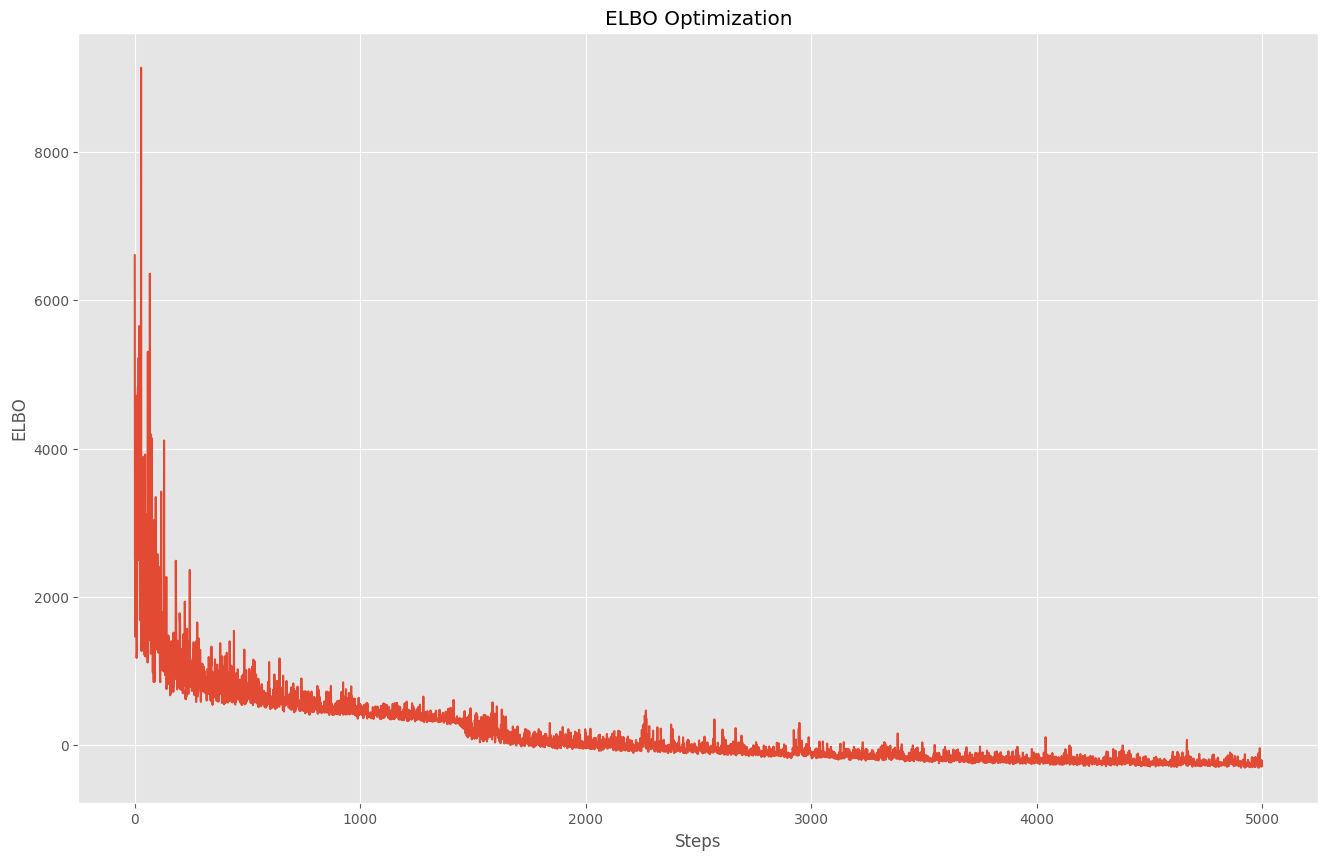

In [86]:
class BNN(PyroModule):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super(BNN, self).__init__()

        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden1)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden1, n_in]).to_event(2))
        self.in_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden1]).to_event(1))

        self.h_layer1 = PyroModule[nn.Linear](n_hidden1, n_hidden2)
        self.h_layer1.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden1]).to_event(2))
        self.h_layer1.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden2, n_hidden2)
        self.h_layer2.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden2]).to_event(2))
        self.h_layer2.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.out_layer = PyroModule[nn.Linear](n_hidden2, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden2]).to_event(2))
        self.out_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_out]).to_event(1))

        self.tanh = nn.Tanh()

    def forward(self, X, y=None):
        X_nn = self.tanh(self.in_layer(X))
        X_nn = self.tanh(self.h_layer1(X_nn))
        X_nn = self.tanh(self.h_layer2(X_nn))
        nn_out = self.out_layer(X_nn).squeeze(-1)

        with pyro.plate("observations", X.shape[0]):
            y = pyro.sample("obs", dist.Normal(nn_out, 0.1), obs=y)

        return nn_out

# Initialize the neural network model
input_dim = X_train.shape[1]  # Number of features in X_train
hidden_dim1 = 10  # Example first hidden layer dimension
hidden_dim2 = 10  # Example second hidden layer dimension
output_dim = 1  # Example output dimension (predicting one value)

model = BNN(n_in=input_dim, n_hidden1=hidden_dim1, n_hidden2=hidden_dim2, n_out=output_dim)

# Define a guide (variational distribution) for SVI
pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# Define SVI
elbo = Trace_ELBO(num_particles=3)
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=elbo)

# Number of optimization steps
n_steps = 5000

# Optimize the model
all_elbo = []
for step in range(n_steps + 1):
    elbo = svi.step(X_train_tensor, y_train_tensor)
    all_elbo.append(elbo)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

# Plot ELBO values
plt.plot(all_elbo)
plt.xlabel('Steps')
plt.ylabel('ELBO')
plt.title('ELBO Optimization')
plt.show()

In [88]:
def plot_forecast(obs_samples, dates, y_set, ylabel, title, train_test_split_date):
    y_mean = obs_samples.mean(axis=0).reshape(-1,)
    y_std = obs_samples.std(axis=0).reshape(-1,)

    forecast_plus_stddev = y_mean + 1.96 * y_std
    forecast_minus_stddev = y_mean - 1.96 * y_std

    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_set, "b-", label="True")
    plt.plot(dates, y_mean, "r-", label="Forecast")
    plt.fill_between(dates, forecast_minus_stddev, forecast_plus_stddev, color='r', alpha=0.15, label="Uncertainty")
    plt.axvline(x=train_test_split_date, color='green', linestyle=':', lw=3, label="Train-test split")
    plt.title(title, size=20)
    plt.xlabel("Time", size=15)
    plt.ylabel(ylabel, size=15)
    plt.legend(fontsize=13)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()

In [87]:
y_train

array([0.15760094, 0.13919575, 0.09506916, 0.05220456, 0.02557607,
       0.        , 0.03562188, 0.06586103, 0.09676422, 0.14584342,
       0.21817782, 0.25483975, 0.28313929, 0.30920049, 0.30332195,
       0.32653172, 0.4205441 , 0.50068106, 0.49243453, 0.43266689,
       0.36240169, 0.29493554, 0.22555177, 0.15369429, 0.09982306,
       0.04628921, 0.04627475, 0.0318126 , 0.02080018, 0.02979424,
       0.06434937, 0.12749067, 0.21339417, 0.29830553, 0.38320778,
       0.40799507, 0.42809931, 0.42684145, 0.44224478, 0.46154512,
       0.54937258, 0.65070337, 0.63666799, 0.52878536, 0.44437817,
       0.38139921, 0.28158679, 0.21474737, 0.13978494, 0.07506279,
       0.0314258 , 0.01488885, 0.05648001, 0.15690471, 0.31571629,
       0.4999031 , 0.60109792, 0.63910324, 0.68059989, 0.6930741 ,
       0.66750298, 0.65160921, 0.62540595, 0.62572908, 0.69873004,
       0.82049498, 0.76663098, 0.62950915, 0.53681768, 0.43916631,
       0.33208497, 0.24176964, 0.18540527, 0.12630465, 0.09517

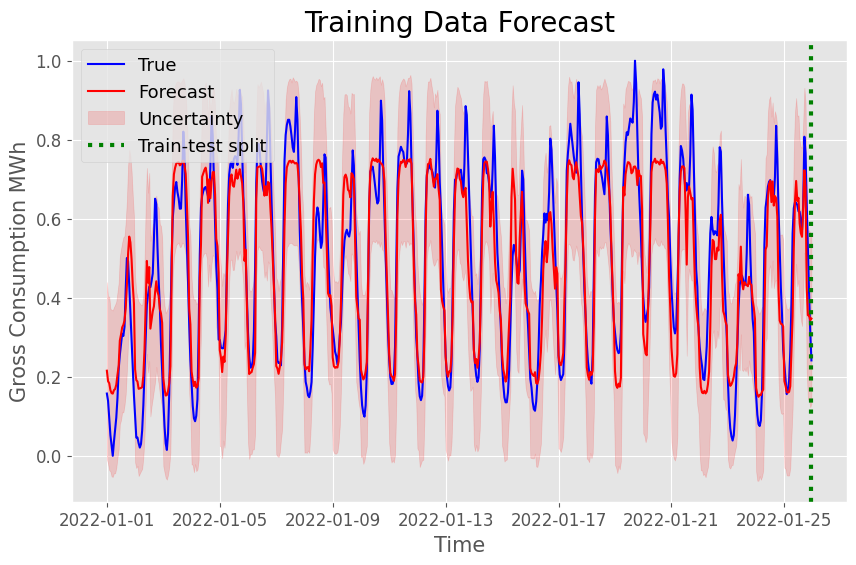

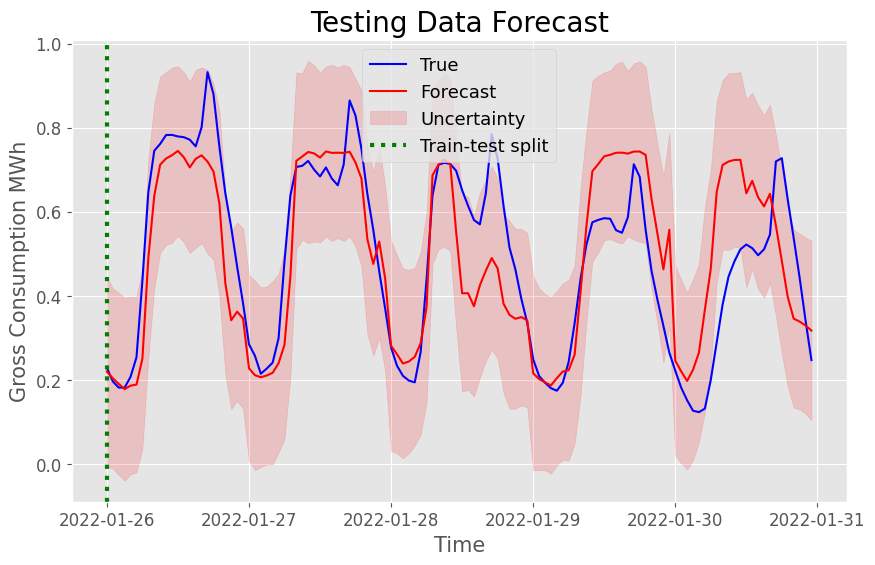

In [89]:
predictive = Predictive(model, guide=guide, num_samples=1000)

# Get predictions for training data
train_samples = predictive(X_train_tensor)
train_obs_samples = train_samples["obs"].detach().numpy()

# Get predictions for test data
test_samples = predictive(X_test_tensor)
test_obs_samples = test_samples["obs"].detach().numpy()

# Convert dates from your dataset for plotting
train_dates = pd.to_datetime(train_data['HourDK'])
test_dates = pd.to_datetime(test_data['HourDK'])

# Plot the training forecast
plot_forecast(train_obs_samples, train_dates, y_train, "Gross Consumption MWh", "Training Data Forecast", train_dates.iloc[-1])

# Plot the testing forecast
plot_forecast(test_obs_samples, test_dates, y_test, "Gross Consumption MWh", "Testing Data Forecast", test_dates.iloc[0])


Mean Absolute Error (MAE): 0.1044
Mean Squared Error (MSE): 0.0181
Mean Percentage Error (MPE): 4.9131%


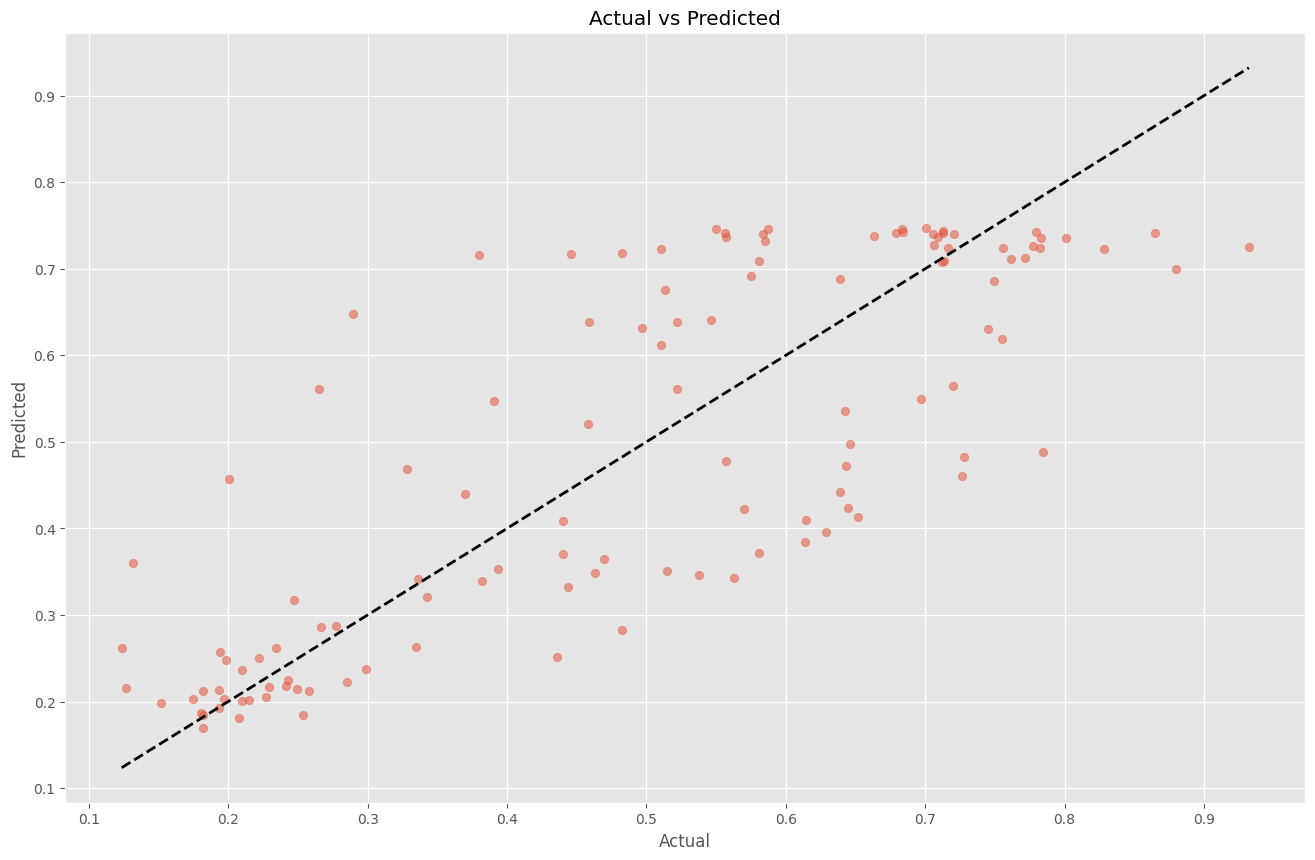

In [90]:
predictive = Predictive(model, guide=guide, num_samples=1000)
samples = predictive(X_test_tensor)

# Calculate mean predictions
y_pred = samples["obs"].mean(dim=0).detach().numpy()

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
# Calculate Mean Percentage Error (MPE)
mpe = abs(np.mean((y_test - y_pred) / y_test) * 100)
print(f"Mean Percentage Error (MPE): {mpe:.4f}%")

# Plot actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()